## Part 2 - PreProcessing & LDA Modeling w/ Gensim

In this notebook, we will begin to do some NLP preprocessing as well as inputing our text data into a vectorizer. We need to do this before we can start to do some modeling, specifically LDA Topic Modeling.

In [1]:
#Importing the holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing NLP plugins
#Spacy Imports
import spacy
from spacy.lang.en import English
nlp_spacy = English()

#NLTK Imports
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

#Gensim Imports
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel as lda_gensim
from gensim.models import CoherenceModel

# Display formatter
import pprint

# Interactive Plotting plugins for anlayzing our LDA topics
import pyLDAvis
import pyLDAvis.gensim
# Initiate pyLDAvis to load in Jupyter Cell
pyLDAvis.enable_notebook()

# We don't need to see the warnings :) 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing our cleaned data for later use:
df = pd.read_csv('data/cleaned_df.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head(3)

,Title,Text,Source
0,Latest Headlines on CNN Business,Disney+ is almost near its subscribers goal fo...,CNN
1,Travel News - CNN,Here are all the animal livestreams and videos...,CNN
2,Rugby World Cup 2019,"By Daniel Gallan, for CNN\r\n\r\nNew Zealand e...",CNN


#### We will first write some functions that will take our data to be LDA anlaysis ready

In [3]:
stop_words = stopwords.words('english')
#Adds cnn to the stop_words list above
stop_words.extend(["cnn","n't"])

#Let's create a tokenizer function
def tokenizer_spacy(text):
    
    token_list = []
    tokens = nlp_spacy(text)
    
    for each_token in tokens:
        
        #Check if its an empty string
        if each_token.orth_.isspace():
            continue
            
        #Check if there is anything in the text that start with @ sign, 
        #such as a twitter handle    
        elif each_token.orth_.startswith('@'):
            continue
            
        #Check if its a url and skips it    
        elif each_token.like_url:
            continue
            
        #check if the token is a digit, we skip it. 
        #Just for simplicity stake of this project
        elif each_token.is_digit:  
            continue
            
        #Check if token is less than or equal to two charactes, then we skip it.
        elif len(each_token) <= 2:
            continue
            
        else:
            #makes each token lower case
            token_list.append(each_token.lower_)
            
    return token_list

def stemmer(token):
    
    return PorterStemmer().stem(token)


def tokenizer_for_list(text_list):
    
    # acquire tokens from our spacy tokenizer function above
    the_tokens = tokenizer_spacy(text_list)
    # removes tokens from our stop words list
    the_tokens = [token for token in the_tokens if token not in stop_words]
    # Send our tokens to be lemmanitized 
    the_tokens = [stemmer(token) for token in the_tokens]
    
    return the_tokens

# FUNCTION TO FORM BIGRAMS
# This is done after tokenizing, since we need to feed our fucntion the tokenized list
def form_bigram_gensim(texts):
    
    bigram_finder = gensim.models.Phrases(texts, min_count = 5, threshold = 75)
    bigram_tokens = gensim.models.phrases.Phraser(bigram_finder)
    
    return [bigram_tokens[tokens] for tokens in texts]


def form_trigram_gensim(texts):
    
    trigram_finder = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    trigram_tokens = gensim.models.phrases.Phraser(trigram_finder)
    
    return [trigram_tokens[tokens] for tokens in texts]

#### Now we got our helper functions ready, lets do some tokenizing and have our data prepped to be ready for our LDA Model.

In [4]:
%%time
#Create a list that holds each body of text
text_data = df['Text'].values.tolist()

# Create an empty list to store our tokenized text data
tokenized_text_data = []

# For Loop to tokenize our data
for each_article in text_data:
    tokens = tokenizer_for_list(each_article)
    tokenized_text_data.append(tokens)
    
# Send our tokenized list to form bigrams and trigrams
tokenized_text_data = form_bigram_gensim(tokenized_text_data)
tokenized_text_data = form_trigram_gensim(tokenized_text_data)

CPU times: user 1min 34s, sys: 796 ms, total: 1min 34s
Wall time: 1min 36s


In [5]:
# Sanity Check
len(tokenized_text_data)

3255

In [6]:
#Here we can see our tokenized data is in the right order
tokenized_text_data[3200]

['singapor',
 'condit',
 'three',
 'dormitori',
 'gazet',
 'isol',
 'area',
 'amid',
 'covid-19',
 'outbreak',
 'continu',
 'improv',
 'ministri',
 'manpow',
 'mom',
 'said',
 'wednesday_apr',
 's11_dormitori_punggol',
 'westlit_toh_guan_dormitori',
 'toh_guan_dormitori',
 'among',
 'worst',
 'hit',
 'viru',
 'advertis',
 'advertis',
 'case',
 'far',
 's11_dormitori',
 'largest',
 'cluster',
 'singapor',
 'westlit_toh_guan_dormitori',
 'total',
 'confirm_case',
 'wednesday',
 'case',
 'link',
 'toh_guan_dormitori',
 'thousand',
 'foreign',
 'worker',
 'live',
 'dormitori',
 'declar',
 'isol',
 'area',
 'infecti_diseas',
 'act',
 'mean',
 'worker',
 'three',
 'dormitori',
 'place',
 'quarantin',
 'stay',
 'room',
 'day',
 'advertis',
 'advertis',
 'mom',
 'announc',
 'tuesday',
 'team',
 'inter',
 'agenc',
 'task_forc',
 'deploy',
 'three',
 'dormitori',
 'support',
 'oper',
 'implement',
 'safe_distanc',
 'measur',
 'distribut',
 'meal',
 'mainten',
 'cleanli',
 'bin',
 'area',
 's11_d

#### Now that we have our data all tokenized and ready! Let us jump into our LDA Topic Modeling with Gensim! 

For this LDA Model, let us start with **20 topics** and go from there!

In [7]:
# creating our dictionary
dictionary = gensim.corpora.Dictionary(tokenized_text_data)

# Creating our bag of words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_text_data]

In [8]:
%%time
from gensim.models import LdaModel as lda_gensim

lda = lda_gensim(num_topics = 20, corpus = corpus, id2word = dictionary)

CPU times: user 23.9 s, sys: 176 ms, total: 24.1 s
Wall time: 6.62 s


In [9]:
#Initate pyLDAvis LDA visualization
lda_visualization = pyLDAvis.gensim.prepare(topic_model = lda,
                                            corpus = corpus,
                                            dictionary = dictionary)
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.017777 -0.072776       1        1  17.540613
18    -0.056102 -0.011687       2        1  14.173698
9     -0.071668  0.047524       3        1  12.263809
19    -0.027526 -0.019368       4        1  11.670213
7     -0.014564 -0.046741       5        1   8.033390
4     -0.021226 -0.015367       6        1   7.103258
10     0.003822 -0.028920       7        1   4.771367
13    -0.025928 -0.020311       8        1   4.507308
8     -0.034375  0.012501       9        1   3.673393
2     -0.038141  0.013172      10        1   2.393582
17     0.002523  0.010425      11        1   2.275731
6      0.044953 -0.026739      12        1   2.156374
16     0.004864  0.023047      13        1   1.810015
3      0.040749 -0.022795      14        1   1.673999
12     0.034361  0.019745      15        1   1.642597
11     0.019929  0.034010      16        1   1.202682
15     0.019910  0.021364      17        1   1.176925
0      0.048624  0.032492      18        1   0.766563
5      0.043954  0.034670      19        1   0.643119
14     0.008064  0.015757      20        1   0.521364, topic_info=           Term          Freq         Total Category  logprob  loglift
206        said  10717.000000  10717.000000  Default  30.0000  30.0000
109       peopl   6439.000000   6439.000000  Default  29.0000  29.0000
103         one   5482.000000   5482.000000  Default  28.0000  28.0000
242  coronaviru   4451.000000   4451.000000  Default  27.0000  27.0000
665        home   3239.000000   3239.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
509      pandem     15.040489   2846.976562  Topic20  -6.0520   0.0132
277      provid     13.591359   2051.706055  Topic20  -6.1533   0.2395
696        make     14.808905   3447.027100  Topic20  -6.0675  -0.1936
369       first     13.931293   2917.525146  Topic20  -6.1286  -0.0879
837       could     13.796050   3095.822266  Topic20  -6.1383  -0.1569

[1657 rows x 6 columns], token_table=       Topic      Freq Term
term                       
17344      9  0.223985  0.4
17344     10  0.447970  0.4
853        2  0.077746  0.5
853        9  0.233238  0.5
853       10  0.544222  0.5
...      ...       ...  ...
8924      16  0.006425  ’ve
8924      17  0.005507  ’ve
8924      18  0.002754  ’ve
8924      19  0.001836  ’ve
8924      20  0.001836  ’ve

[7484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 8, 5, 11, 14, 9, 3, 18, 7, 17, 4, 13, 12, 16, 1, 6, 15])

In [10]:
#Lets export our models for future use:
import joblib
#Saving model
joblib.dump(lda, 'lda_models/gensim_lda_20_20200410.pkl')

#Saving LDA Visulization
pyLDAvis.save_html(lda_visualization, 'lda_models/gensim_lda+_viz_20_20200410.html')

#### How to evaluate our topic models? 
Our LDA Model has now run, and 20 topics have been grouped. What's great about plyDAVis is that it is very interactive, we can hover around the vaious topics, and check them out. However, how do we actually know if our model did a good job grouping our texts files aka. our **corpus**"?

The simplest method is to visually anlayzing our topics, check out the top 10 to 30 most associated words and determine if they make sense. However, there are more sophisticated ways to do this with a combination of intrinsic evaluation metrics, extrinsic evaluation metrics, and the good ole human judgement. 

**Gensim has a built in evaluation metric for our generated topics. We can evaluate this by determining the topic coherence score. The question now is...what is topic coherence?**

[Taken from a lovely medium post on it by Shashank Kapadi](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

> Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

However, if you want to go deeper in the nitty gritty stuff of Topic Coherence, check out this [paper!](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

**By extracting the topic coherence, we could do some hyperperameter tuning to find the optimal number of topics that we should search for!** Since we're doing unsupervised learning, we're kinda shooting the model in the dark with 20 topics and see what it comes up with. Now, let's see how we could do it in practice! 

#### Hyperperameter Tuning & Evaluating our LDA Topic Models: Finding the optimal number of topics.



In [11]:
from gensim.models import CoherenceModel

#Let's check our coherence score with our original LDA model with 20 topics
#and use that as our benchmarkl
coherence_score_test = CoherenceModel(model = lda, texts = tokenized_text_data,
                                     dictionary = dictionary)

#Show coherence score
coherence_score_test.get_coherence()

0.3440674529450699

A Coherence Score of 0.34, this will be our benchmark.

In [12]:
# Treat this as some sort of accuracy score for optimal number of topics
coherence_score_values = []
model_list = []

In [13]:
%%time 

for i in np.arange(10,31):
    #Inialize Gensim's LDA Model
    lda_model_loop = lda_gensim(num_topics = i, 
                                corpus = corpus, 
                                id2word = dictionary)
    
    model_list.append(lda_model_loop)
    
    coherence_model = CoherenceModel(model = lda_model_loop, texts = tokenized_text_data,
                                    dictionary = dictionary)
    
    coherence_score_values.append(coherence_model.get_coherence())
    #Check Progress
    print(f'LDA Model and Coherence score calculated for num_topics = {i}.')

LDA Model and Coherence score calculated for num_topics = 10.
LDA Model and Coherence score calculated for num_topics = 11.
LDA Model and Coherence score calculated for num_topics = 12.
LDA Model and Coherence score calculated for num_topics = 13.
LDA Model and Coherence score calculated for num_topics = 14.
LDA Model and Coherence score calculated for num_topics = 15.
LDA Model and Coherence score calculated for num_topics = 16.
LDA Model and Coherence score calculated for num_topics = 17.
LDA Model and Coherence score calculated for num_topics = 18.
LDA Model and Coherence score calculated for num_topics = 19.
LDA Model and Coherence score calculated for num_topics = 20.
LDA Model and Coherence score calculated for num_topics = 21.
LDA Model and Coherence score calculated for num_topics = 22.
LDA Model and Coherence score calculated for num_topics = 23.
LDA Model and Coherence score calculated for num_topics = 24.
LDA Model and Coherence score calculated for num_topics = 25.
LDA Mode

**NOTE: Above line of code may take a while.** I'm using a 2016 Macbook Pro.

Now that our loop has been completed. Let us plot this out to see if we could find an optimal number of topics to use with our dataset.

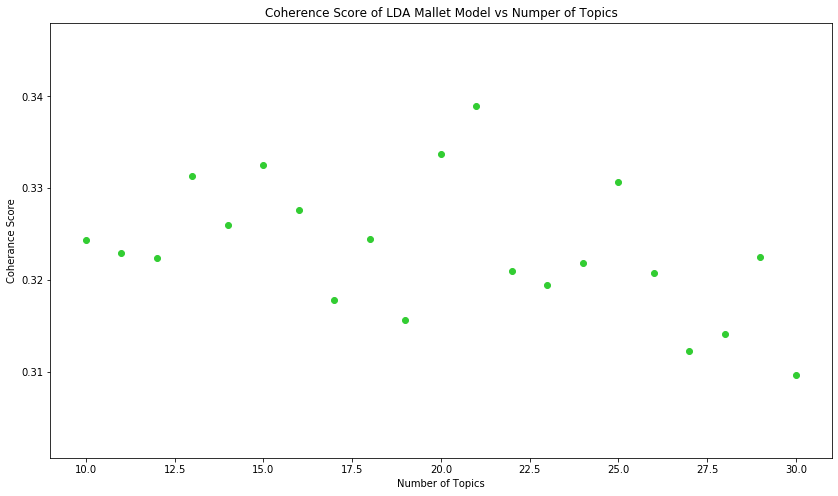

In [18]:
plt.figure(figsize = (14,8))
plt.scatter(x = np.arange(10,31), y = coherence_score_values, color = 'limegreen')
plt.xlabel('Number of Topics')
plt.ylabel('Coherance Score')
plt.title('Coherence Score of LDA Mallet Model vs Numper of Topics')
plt.show()

From a quick glance at our plot. It seems an LDA model with 21 topics is the optimal coherence score. 

In [19]:
optimal_num_topics = coherence_score_values.index(max(coherence_score_values))
print(coherence_score_values.index(max(coherence_score_values)))

11


In [24]:
#11 on the np index = to 21 topics, since we started at 10 on the loop. 
print(coherence_score_values[11])

0.33893266863377386


**Rookie mistake:** Should have used a seed because it seems in my loop 21 topics is the max coherence score, but the model i did before suggests otherwise. But even from the scatter plot, there is a small marginal difference in each increase of topic. This is because, my dataset is rather small and I need to garner more data and possibly keep this going to 100 topics. The default num_topics in gensim is 100.

**Another Rookie Mistake:** I should have pickled each model and the results for each loop so I could have loaded it up whenever I wanted to. 

In [25]:
#Anyways, let's just move forward and run the model again, and save it into a pickle file.


#based on our coherence model graph, 21 is optimal topics. 
lda_optimzed = lda_gensim(num_topics = 21, 
                                corpus = corpus, 
                                id2word = dictionary)


#dump our model into pickle file
joblib.dump(lda, 'lda_models/gensim_lda_21_20200413.pkl')

['lda_models/gensim_lda_21_20200413.pkl']

In [26]:
#Let us create the visualization as well
lda_viz_21_topics = pyLDAvis.gensim.prepare(topic_model = lda_optimzed,
                                            corpus = corpus,
                                            dictionary = dictionary)
#Also Save the html for later use
pyLDAvis.save_html(lda_viz_21_topics, 'lda_models/gensim_lda+_viz_21_20200413.html')

#display visualization
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.017777 -0.072776       1        1  17.540613
18    -0.056102 -0.011687       2        1  14.173698
9     -0.071668  0.047524       3        1  12.263809
19    -0.027526 -0.019368       4        1  11.670213
7     -0.014564 -0.046741       5        1   8.033390
4     -0.021226 -0.015367       6        1   7.103258
10     0.003822 -0.028920       7        1   4.771367
13    -0.025928 -0.020311       8        1   4.507308
8     -0.034375  0.012501       9        1   3.673393
2     -0.038141  0.013172      10        1   2.393582
17     0.002523  0.010425      11        1   2.275731
6      0.044953 -0.026739      12        1   2.156374
16     0.004864  0.023047      13        1   1.810015
3      0.040749 -0.022795      14        1   1.673999
12     0.034361  0.019745      15        1   1.642597
11     0.019929  0.034010      16        1   1.202682
15     0.019910  0.021364      17        1   1.176925
0      0.048624  0.032492      18        1   0.766563
5      0.043954  0.034670      19        1   0.643119
14     0.008064  0.015757      20        1   0.521364, topic_info=           Term          Freq         Total Category  logprob  loglift
206        said  10717.000000  10717.000000  Default  30.0000  30.0000
109       peopl   6439.000000   6439.000000  Default  29.0000  29.0000
103         one   5482.000000   5482.000000  Default  28.0000  28.0000
242  coronaviru   4451.000000   4451.000000  Default  27.0000  27.0000
665        home   3239.000000   3239.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
509      pandem     15.040489   2846.976562  Topic20  -6.0520   0.0132
277      provid     13.591359   2051.706055  Topic20  -6.1533   0.2395
696        make     14.808905   3447.027100  Topic20  -6.0675  -0.1936
369       first     13.931293   2917.525146  Topic20  -6.1286  -0.0879
837       could     13.796050   3095.822266  Topic20  -6.1383  -0.1569

[1657 rows x 6 columns], token_table=       Topic      Freq Term
term                       
17344      9  0.223985  0.4
17344     10  0.447970  0.4
853        2  0.077746  0.5
853        9  0.233238  0.5
853       10  0.544222  0.5
...      ...       ...  ...
8924      16  0.006425  ’ve
8924      17  0.005507  ’ve
8924      18  0.002754  ’ve
8924      19  0.001836  ’ve
8924      20  0.001836  ’ve

[7484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 8, 5, 11, 14, 9, 3, 18, 7, 17, 4, 13, 12, 16, 1, 6, 15])

We will do some our model anlaysis on a seperate notebook later on. Please visit Updated - Part 4 - Model Anlaysis. 

#### Before we go there I will be using some helper functions to catogrize our text data with the topics generated from our LDA model.

The following helper functions were inspired and taken from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#19findthemostrepresentativedocumentforeachtopic


In [48]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [49]:
df_topic_sents_keywords = format_topics_sentences(lda_optimzed, 
                                                  corpus, 
                                                  text_data)

In [55]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#Adding our Original Source
df_dominant_topic['Source'] = df['Source']


In [56]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Source
0,0,10.0,0.9047,"said, coronaviru, year, govern, would, countri...",Disney+ is almost near its subscribers goal fo...,CNN
1,1,13.0,0.8412,"said, work, say, one, also, n’t, peopl, year, ...",Here are all the animal livestreams and videos...,CNN
2,2,15.0,0.5748,"said, would, coronaviru, health, like, year, o...","By Daniel Gallan, for CNN\r\n\r\nNew Zealand e...",CNN


In [57]:
df_dominant_topic.to_csv('labeled_data_gensim_LDA_21.csv')